In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize':(10,7)})

### Things to do:

1. Exploratory Data Analysis 
2. Pre-processing
3. Feature engineering 
4. Model evaluation
    - Split train dataset into train and validation 
    - Compare different models - RF, Regression (LASSO/Ridge Regression), Gradient Boosted Trees
    - Metrics (RMSE), Variable importance (for explanation)
    - LIME (Local Interpretability Model Agnostic)
5. Report / Slide Deck

### Team Meeting 3rd March

Areas to raise:
- Feature engineering
- Outlier detection 


Follow ups:
- Feature engineering for extra datasets
- Baseline, first-cut model
- Slide deck to document down goals and questions, EDA results, first design decisions or results, issues/challenges/obstacles.

In [26]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

## Feature Engineering / Pre-processing

Categorical columns with too many columns, might not be useful as predictors:
-  `town`, `block`, `street_name`, `subzone`, `planning_area`

Columns with no variation - DROP them:
- `elevation`, `eco_category`

In [27]:
train['year'] = train.month.str[:4].astype('int')
train['price_per_area'] = train['resale_price']/train['floor_area_sqm']
train['lease_duration'] = train['year']-train['lease_commence_date']
train['storey'] = (train.storey_range.str[-2:].astype('int') + train.storey_range.str[:2].astype('int'))/2
train['flat_type'] = train['flat_type'].str.replace('-', ' ') # there are some flat_type encoded as 4-room and 4 room

# flat_type as ordinal variables (either this or the one after)
train['flat_type_ord'] = train.flat_type.map({
    '1 room':1,
    '2 room':2,
    '3 room':3,
    '4 room':4,
    '5 room':5,
    'executive':6,
    'multi generation': 7
})

# region as dummies
train = pd.get_dummies(train, columns=['flat_model', 'town', 'year'], drop_first=True)

# flat_type as categorical variable (either this or the one before)
# train = pd.get_dummies(train, columns=["flat_type"], drop_first=False)
# train.drop(columns = 'flat_type_multi generation') # dropping this since it is the least frequent among all flat types

train.drop(columns = ['elevation', 'eco_category', 'flat_type', 'month'], inplace=True) # confirm drop
train.drop(columns = ['storey_range', 'region', 'block', 'street_name', 'subzone', 'planning_area', 'lease_commence_date'], inplace=True) # to discuss

In [34]:
train.to_csv('../data/processed/preprocessed_080321.csv', index=False)

## Data Exploration

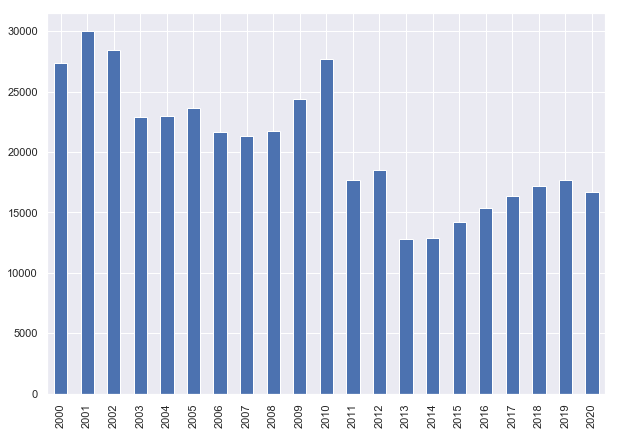

In [57]:
# volume of transactions is lower after 2010 
train.year.value_counts().sort_index().plot(kind='bar')
plt.show()

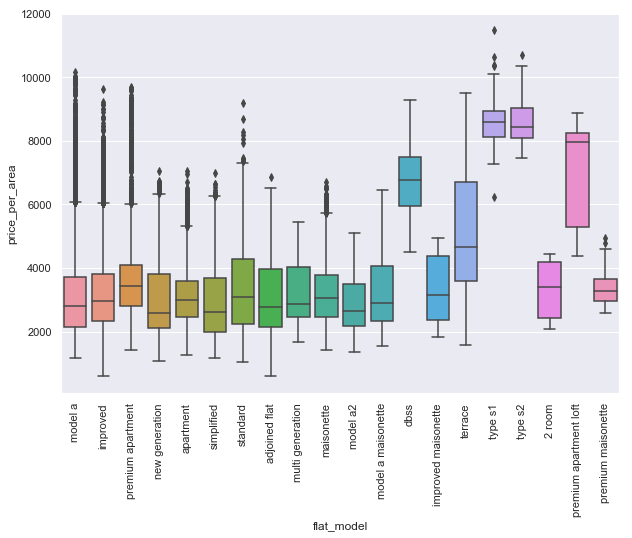

In [95]:
p = sns.boxplot(x='flat_model',y='price_per_area', data=train)
plt.xticks(rotation=90)
plt.show()

# seems to make a difference for type s1, s2 - many categories though

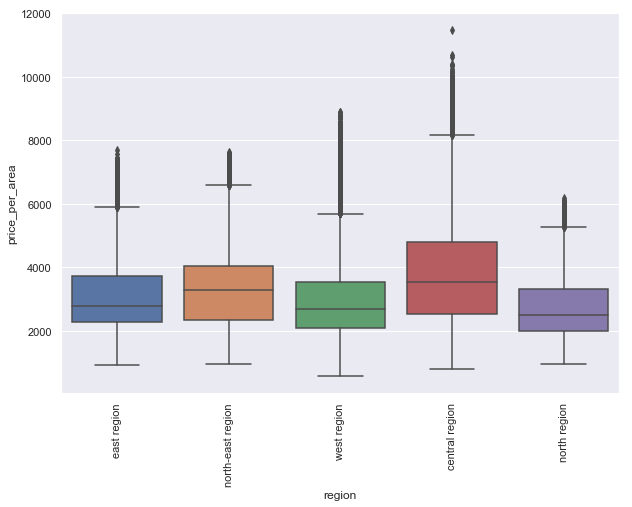

In [93]:
p = sns.boxplot(x='region',y='price_per_area', data=train)
plt.xticks(rotation=90)
plt.show()

# central region more expensive :O 

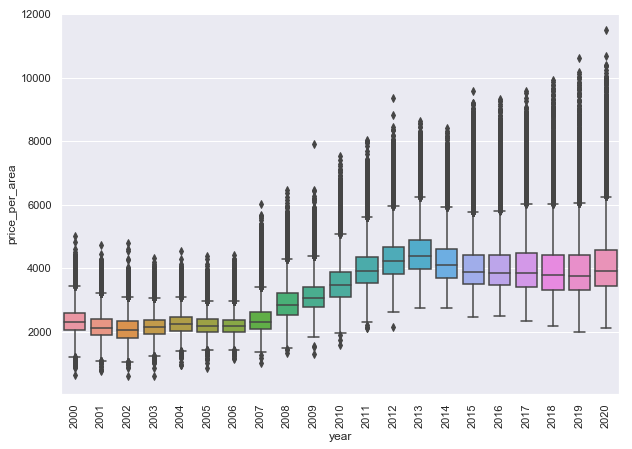

In [91]:
p = sns.boxplot(x='year',y='price_per_area', data=train)
plt.xticks(rotation=90)
plt.show()

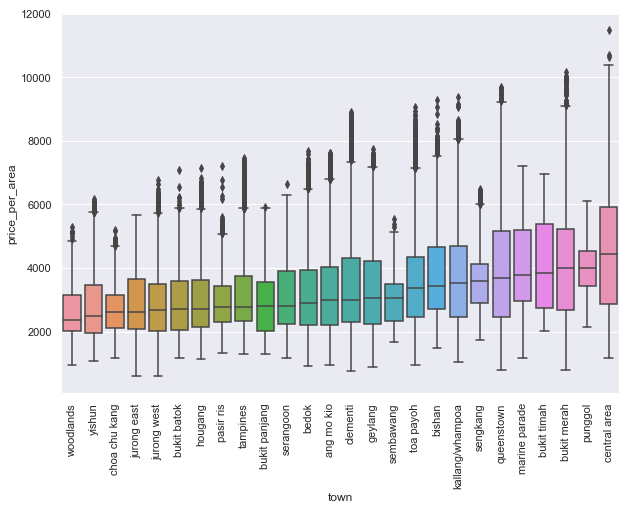

In [56]:
order = train.groupby('town').price_per_area.agg('median').sort_values().index
p = sns.boxplot(x='town',y='price_per_area', data=train, order=order)
plt.xticks(rotation=90)
plt.show()

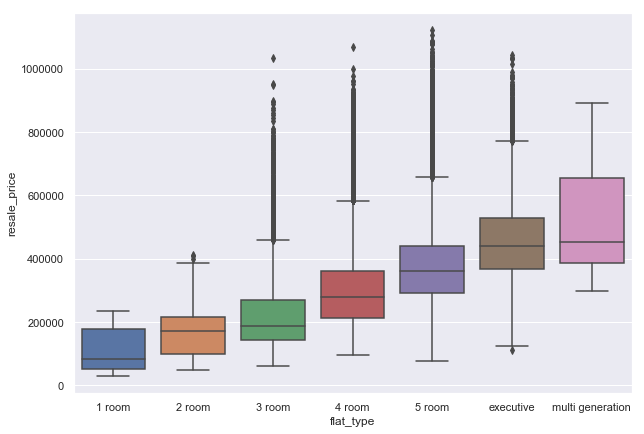

In [56]:
order_flat = train.groupby('flat_type')['floor_area_sqm'].median().index
sns.boxplot(x='flat_type',y='resale_price', data=train, order=order_flat)
plt.show()

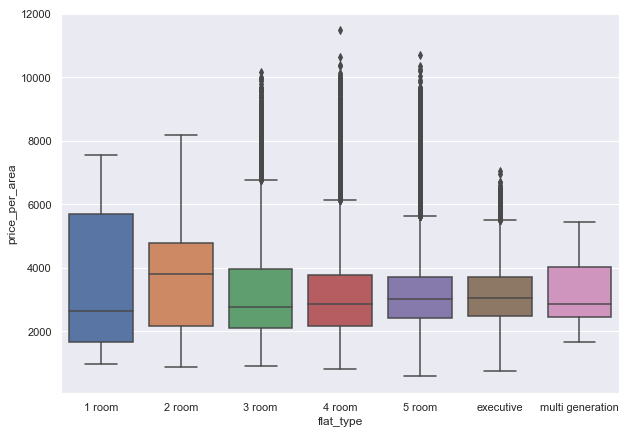

In [57]:
sns.boxplot(x='flat_type',y='price_per_area', data=train, order=order_flat)
plt.show()

# afer accounting for area, doesn't seem to have much difference in price per area for different flat types. for 3-room to executive, lots of outliers
# we can either choose to model this as a categorical variable or ordinal variable (can try both) 

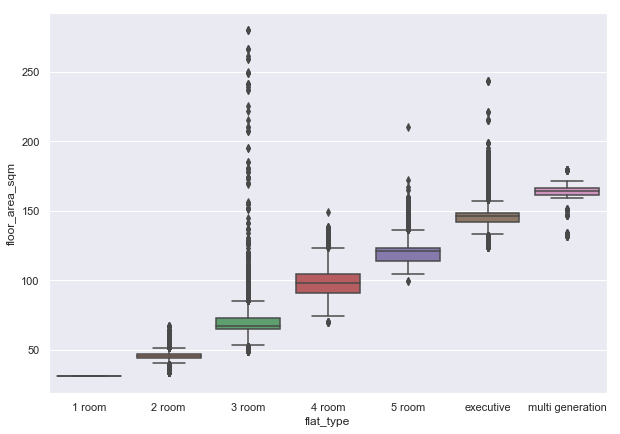

In [60]:
sns.boxplot(x=train['flat_type'], y=train['floor_area_sqm'], order=order_flat)
plt.show()

# a lot of outliers on 3 room flat - some damn big

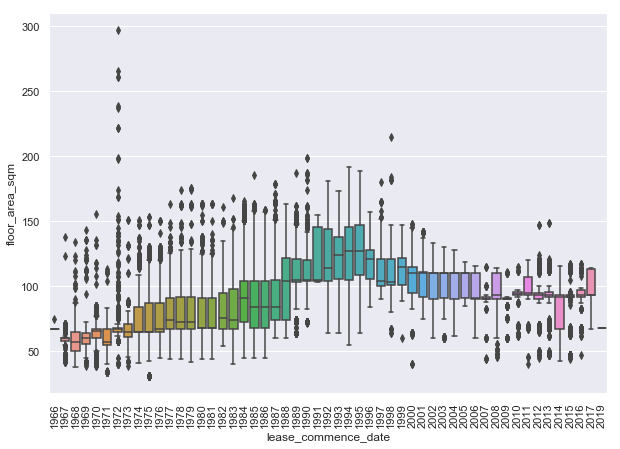

In [125]:
sns.boxplot(x=test['lease_commence_date'],y=test['floor_area_sqm'])
plt.xticks(rotation=90)
plt.show()

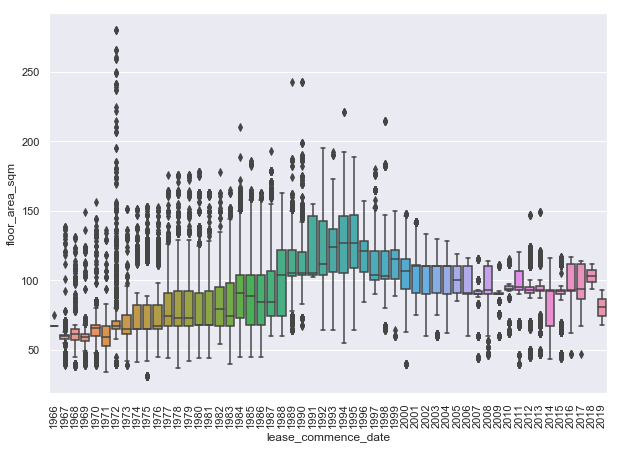

In [139]:
sns.boxplot(x=train['lease_commence_date'],y=train['floor_area_sqm'])
plt.xticks(rotation=90)
plt.show()

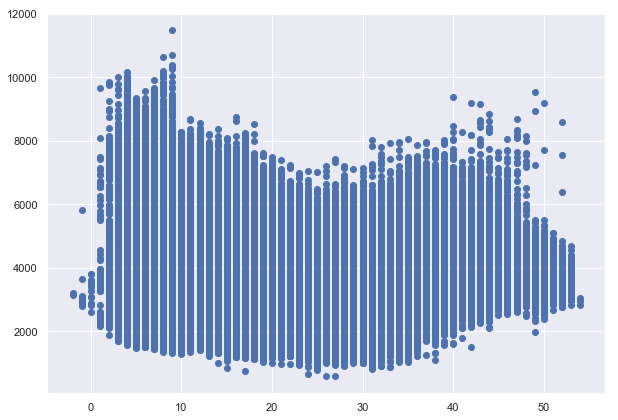

In [79]:
# no clear relationship 
plt.scatter(x=train['lease_duration'],y=train['price_per_area'])
plt.show()

In [78]:
train[['lease_duration', 'price_per_area']].corr(method='pearson')

,lease_duration,price_per_area
lease_duration,1.000000,0.212324
price_per_area,0.212324,1.000000


### Other Datasets

In [97]:
pri_sch = pd.read_csv('../data/raw/sg-primary-schools.csv')
sec_sch = pd.read_csv('../data/raw/sg-secondary-schools.csv')
malls = pd.read_csv('../data/raw/sg-shopping-malls.csv')
mrt = pd.read_csv('../data/raw/sg-train-stations.csv')
hawker = pd.read_csv('../data/raw/sg-gov-markets-hawker-centres.csv')
cc = pd.read_csv('../data/raw/sg-commerical-centres.csv')
demo = pd.read_csv('../data/raw/sg-population-demographics.csv')

In [109]:
print(demo.shape)
demo.head()

(7836, 5)


,plannin_area,subzone,age_group,sex,count
0,ang mo kio,ang mo kio town centre,0-4,m,130
1,ang mo kio,cheng san,0-4,m,670
2,ang mo kio,chong boon,0-4,m,460
3,ang mo kio,kebun bahru,0-4,m,380
4,ang mo kio,sembawang hills,0-4,m,90


In [110]:
demo[demo['subzone']=="ang mo kio town centre"]

,plannin_area,subzone,age_group,sex,count
0,ang mo kio,ang mo kio town centre,0-4,m,130
218,ang mo kio,ang mo kio town centre,5-9,m,130
435,ang mo kio,ang mo kio town centre,10-14,m,160
649,ang mo kio,ang mo kio town centre,15-19,m,140
865,ang mo kio,ang mo kio town centre,20-24,m,130
1080,ang mo kio,ang mo kio town centre,25-29,m,140
1300,ang mo kio,ang mo kio town centre,30-34,m,160
1524,ang mo kio,ang mo kio town centre,35-39,m,200
1752,ang mo kio,ang mo kio town centre,40-44,m,240
1980,ang mo kio,ang mo kio town centre,45-49,m,210


In [107]:
print(cc.shape)
cc.head()

(38, 4)


,name,type,lat,lng
0,Central Business District,CR,1.286768,103.854529
1,Jurong Lake District,CR,1.334085,103.734513
2,Seletar Regional Centre,CR,1.409435,103.866820
3,Tampines Regional Centre,CR,1.353180,103.945188
4,Woodlands Regional Centre,CR,1.436748,103.786485


In [108]:
cc.type.value_counts()

IEBP    19
BN       8
IHL      5
CR       5
IEPB     1
Name: type, dtype: int64

In [106]:
print(hawker.shape)
hawker.head()

(114, 3)


,name,lat,lng
0,East Coast Lagoon Food Village,1.307730,103.934303
1,Jurong West Hawker Centre,1.341223,103.697374
2,Bukit Merah View Blk 115 (Blk 115 Bukit Merah ...,1.285240,103.822372
3,Geylang Bahru Blk 69 (Blk 69 Geylang Bahru Mar...,1.321530,103.870071
4,Ghim Moh Road Blk 20,1.311060,103.788292


In [105]:
print(mrt.shape)
mrt.head()

(166, 6)


,name,codes,lat,lng,opening_year,type
0,Eunos,EW7,1.319778,103.903252,1989.0,mrt
1,Chinese Garden,EW25,1.342352,103.732596,1988.0,mrt
2,Khatib,NS14,1.417383,103.832980,1988.0,mrt
3,Kranji,NS7,1.425177,103.762165,1996.0,mrt
4,Redhill,EW18,1.289562,103.816816,1988.0,mrt


In [101]:
print(malls.shape)
malls.head()

(174, 4)


,name,lat,lng,wikipedia_link
0,100 AM,1.275012,103.841372,NaN
1,313@Somerset,1.301013,103.838540,NaN
2,Aperia,1.309714,103.863837,NaN
3,Balestier Hill Shopping Centre,1.325442,103.842521,NaN
4,Bugis Cube,1.298276,103.855555,NaN


In [103]:
malls.wikipedia_link.value_counts().head()

/wiki/Marina_Bay_Sands    2
/wiki/Marina_One          1
/wiki/Marina_Square       1
/wiki/Jem,_Singapore      1
/wiki/Square_2            1
Name: wikipedia_link, dtype: int64

In [104]:
malls[~malls['wikipedia_link'].isna()].head()

,name,lat,lng,wikipedia_link
5,Bugis Junction,1.299953,103.855278,/wiki/Bugis_Junction
6,Bugis+,1.299953,103.855278,/wiki/Bugis%2B
7,Capitol Piazza,1.293020,103.850981,/wiki/Capitol_Piazza
8,Cathay Cineleisure Orchard,1.301447,103.836481,/wiki/Cathay_Cineleisure_Orchard
10,The Centrepoint,1.301835,103.839713,/wiki/The_CentrePoint


In [100]:
print(sec_sch.shape)
sec_sch.head()

(150, 3)


,name,lat,lng
0,Admiralty Secondary School,1.445912,103.802908
1,Ahmad Ibrahim Secondary School,1.436095,103.830055
2,Anderson Secondary School,1.375417,103.851723
3,Anglican High School,1.330218,103.941759
4,Anglo-Chinese School (Barker Road),1.319709,103.835661


In [99]:
print(pri_sch.shape)
pri_sch.head()

(191, 3)


,name,lat,lng
0,Admiralty Primary School,1.442941,103.800345
1,Ahmad Ibrahim Primary School,1.433849,103.832710
2,Ai Tong School,1.360713,103.833018
3,Alexandra Primary School,1.291284,103.824066
4,Anchor Green Primary School,1.390380,103.887354
